### Create animation for all the frames in one AOI

In [1]:
# input images path & predicted npy files path
# src_img_root = '/Midgard/Data/hfang/sn7/test_public'
src_img_root = '/Midgard/Data/hfang/sn7/train'
pred_root = '/Midgard/home/hfang/temporal_CD/Berzelius_HRNet_SN7/berzelius_seg_hrnet_tcr_w48_512x512_sgd_lr1e-3_wd1e-4_bs_64_epoch70_alpha_05_train/npy_compose'

In [2]:
import os
import re
import time
import random
import sys
import multiprocessing
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from PIL import Image
import cv2
import skimage.io
from skimage.draw import polygon
from skimage import measure
from skimage.segmentation import watershed
# from skimage.feature import peak_local_max

# import bug-free peak_local_max
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from peak import peak_local_max

from scipy import ndimage as ndi
from rasterio import features

import solaris as sol
from shapely.ops import cascaded_union
from shapely.geometry import shape, Polygon

In [3]:
# dictionary: key -> AOI, value -> npy_files
dic = {}
npy_files = [os.path.join(pred_root, x) for x in os.listdir(pred_root)]
for npy_file in npy_files:
    key = '_'.join(npy_file.split('/')[-1].split('.')[0].split('_')[5:])
    if key not in dic:
        dic[key] = [npy_file]
    else:
        dic[key].append(npy_file)
        
params = []
for aoi, npy_list in dic.items():
    print("Process:", aoi)
    params.append(npy_list)

Process: L15-0566E-1185N_2265_3451_13
Process: L15-1276E-1107N_5105_3761_13
Process: L15-1015E-1062N_4061_3941_13
Process: L15-0632E-0892N_2528_4620_13
Process: L15-1615E-1206N_6460_3366_13
Process: L15-1438E-1134N_5753_3655_13
Process: L15-1848E-0793N_7394_5018_13
Process: L15-0387E-1276N_1549_3087_13
Process: L15-1200E-0847N_4802_4803_13
Process: L15-1690E-1211N_6763_3346_13


In [4]:
# hyperparameters
thres1 = 0

In [5]:
npy_list = dic['L15-1015E-1062N_4061_3941_13']
# npy_list = dic['L15-0387E-1276N_1549_3087_13']
# npy_list = dic['L15-1438E-1134N_5753_3655_13']
# npy_list = dic['L15-1690E-1211N_6763_3346_13']

In [6]:
def get_respond_img(npy_file):
    sp = npy_file.split('.')[0].split('_')
    aoi = '_'.join(sp[5:])
    src_img_path = os.path.join(src_img_root, aoi, "images_masked", npy_file.replace(".npy", ".tif"))
    return src_img_path

def get_respond_gt(npy_file):
    sp = npy_file.split('.')[0].split('_')
    aoi = '_'.join(sp[5:])
    gt_img_path = os.path.join(src_img_root, aoi, "masks", npy_file.replace(".npy", "_Buildings.tif"))
    return gt_img_path

In [7]:
import matplotlib as mpl
import matplotlib.cm as cmx
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.rcParams.update({'font.size': 16})
mpl.rcParams['figure.dpi'] = 300
from matplotlib import animation

# HTML 
from IPython.display import HTML

In [8]:
# create lists of input images, probability maps, segmentation maps, ground truth images
npy_list = sorted(npy_list)
npy_sum = 0
ignore_sum = 0
npys = []
ignore_masks = []
src_imgs = []
gt_imgs = []
proba_imgs = []

for iii, npy_file in enumerate(npy_list):
    npy = np.load(npy_file)
    # Avoid change of original probability map
    proba_img = np.load(npy_file)
    proba_imgs.append(proba_img)
    img_file = get_respond_img(npy_file.split('/')[-1])
    src_img = skimage.io.imread(img_file)
    src_imgs.append(src_img)

    gt_file = get_respond_gt(npy_file.split('/')[-1])
    gt_img = skimage.io.imread(gt_file)
    gt_imgs.append(gt_img)
    
    mask = src_img[:,:,3]==0
    mask = np.repeat(mask, 3, axis=0)
    mask = np.repeat(mask, 3, axis=1)
    assert mask.shape[0]== src_img.shape[0] * 3 and mask.shape[1] == src_img.shape[1] * 3
    
    npy = npy[:mask.shape[0], :mask.shape[1]]
    npy[mask] = -10000
    npys.append(npy)

    ignore_mask = (npy > thres1)
    ignore_masks.append(ignore_mask)
    npy_sum = npy_sum + npy * ignore_mask
    ignore_sum = ignore_sum + ignore_mask

In [9]:
npy_mean = npy_sum / np.maximum(ignore_sum, 1)

npys = np.array(npys)
img_num = npys.shape[0]
print(img_num)

npy_mean_alter = npy_sum / img_num

18


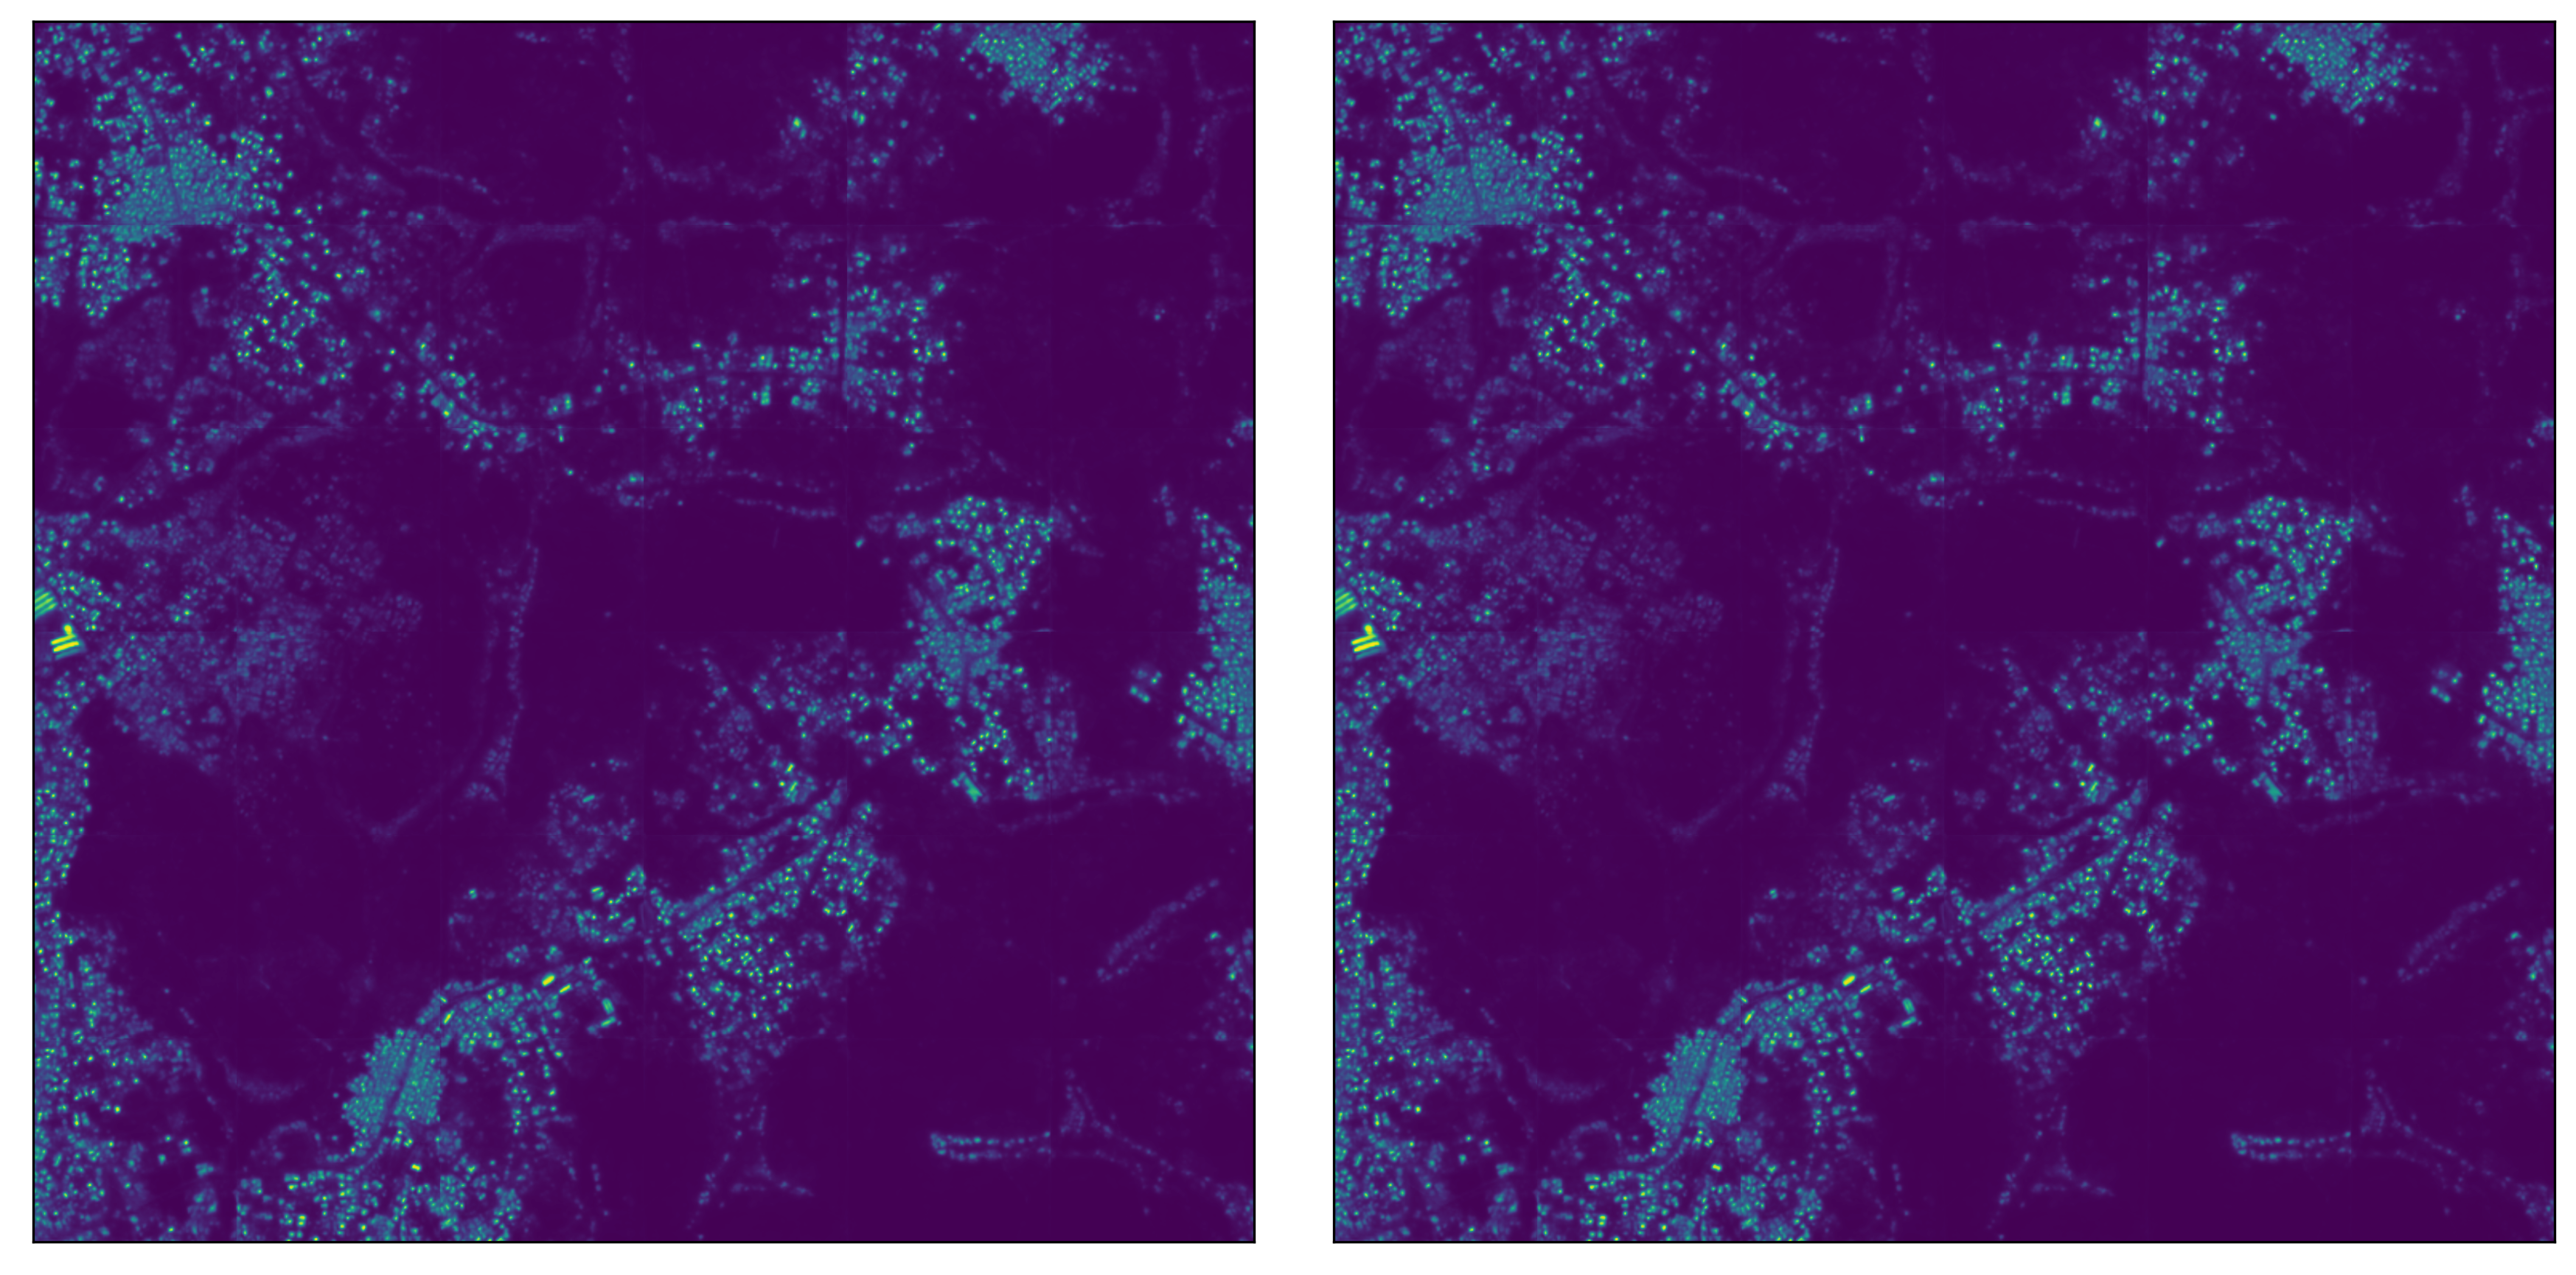

In [10]:
figsize=(12, 6)
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=figsize)
_ = ax0.imshow(npy_mean)
ax0.set_xticks([])
ax0.set_yticks([])
_ = ax1.imshow(npy_mean_alter)
ax1.set_xticks([])
ax1.set_yticks([])
plt.tight_layout()

In [ ]:
figsize=(24, 6)
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=figsize)
_ = ax0.imshow(src_imgs[8])
ax0.set_xticks([])
ax0.set_yticks([])
_ = ax1.imshow(proba_imgs[8])
ax1.set_xticks([])
ax1.set_yticks([])
_ = ax2.imshow(ignore_masks[8])
ax2.set_xticks([])
ax2.set_yticks([])
_ = ax3.imshow(gt_imgs[8])
ax3.set_xticks([])
ax3.set_yticks([])
plt.tight_layout()

In [ ]:
def create_animation(src_imgs, proba_imgs, ignore_masks, gt_imgs):
    """
    Create a Matplotlib animation of the given images.
    """
    plt.ioff()
    figsize=(24, 6)
    fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=figsize)
    plt.ion()
    
    def animation_func(i):
        _ = ax0.imshow(src_imgs[i])
        ax0.set_xticks([])
        ax0.set_yticks([])
        _ = ax1.imshow(proba_imgs[i])
        ax1.set_xticks([])
        ax1.set_yticks([])
        _ = ax2.imshow(ignore_masks[i])
        ax2.set_xticks([])
        ax2.set_yticks([])
        _ = ax3.imshow(gt_imgs[i])
        ax3.set_xticks([])
        ax3.set_yticks([])
        
    anim = animation.FuncAnimation(fig, animation_func, frames=len(src_imgs), interval=1000)
    
    plt.close(fig)
    return anim

anim = create_animation(src_imgs[::1], proba_imgs[::1], ignore_masks[::1], gt_imgs[::1])
%time anim.save('L15-1015E-1062N_4061_3941_13_alpha_1.gif', writer='pillow')
# %time anim.save('L15-0387E-1276N_1549_3087_13.gif', writer='pillow')
# %time anim.save('L15-1438E-1134N_5753_3655_13.gif', writer='pillow')
# %time anim.save('L15-1690E-1211N_6763_3346_13_alpha_1.gif', writer='pillow')

# HTML(anim.to_html5_video())

In [ ]:
print(animation.writers.list())